# Homework 1

To answer the following questions, consider using the sklearn API documentation and the notebooks in
the course webpage as guidance. Show in your PDF report both the code and the corresponding results.
Consider the column_diagnosis.arff data available at the homework tab, comprising 6 biomechanical
features to classify 310 orthopaedic patients into 3 classes (normal, disk hernia, spondilolysthesis). 

In [2]:
import pandas as pd
from scipy.io.arff import loadarff

data = loadarff('data/column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')


df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


1) Apply f_classif from sklearn to assess the discriminative power of the input variables.
Identify the input variable with the highest and lowest discriminative power.
Plot the class-conditional probability density functions of these two input variables.

In [3]:
from sklearn.feature_selection import f_classif

X, y = df.drop('class', axis=1), df['class']

scores = list(zip(X.columns.values, f_classif(X, y)[0]))
scores.sort(key=(lambda x: x[1]))

print(scores)

[('pelvic_radius', 16.86693475538006), ('pelvic_tilt', 21.299194328989202), ('sacral_slope', 89.64395329777439), ('pelvic_incidence', 98.53970917437658), ('lumbar_lordosis_angle', 114.98284047330131), ('degree_spondylolisthesis', 119.12288060759764)]


- Highest discriminative power: degree_spondylolisthesis
- Lowest discrimanitive power: pelvic_radius

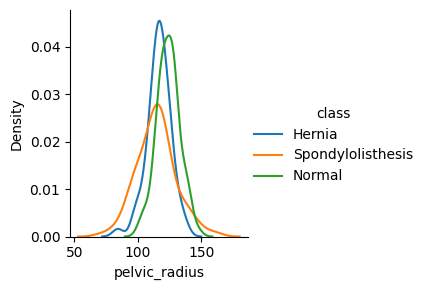

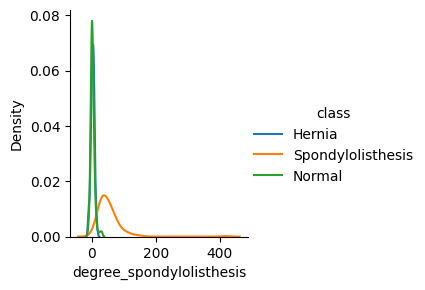

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Meter histogramas ou densidade estimada (kernel)

plot = sns.FacetGrid(df, hue="class")
plot.map(sns.kdeplot, "pelvic_radius").add_legend()
  
plot = sns.FacetGrid(df, hue="class")
plot.map(sns.kdeplot, "degree_spondylolisthesis").add_legend()
  
plt.show()

2) Using a stratified 70-30 training-testing split with a fixed seed (random_state=0), assess in a
single plot both the training and testing accuracies of a decision tree with depth limits in
{1,2,3,4,5,6,8,10} and the remaining parameters as default.

[optional] Note that split thresholding of numeric variables in decision trees is non-deterministic
in sklearn, hence you may opt to average the results using 10 runs per parameterization.

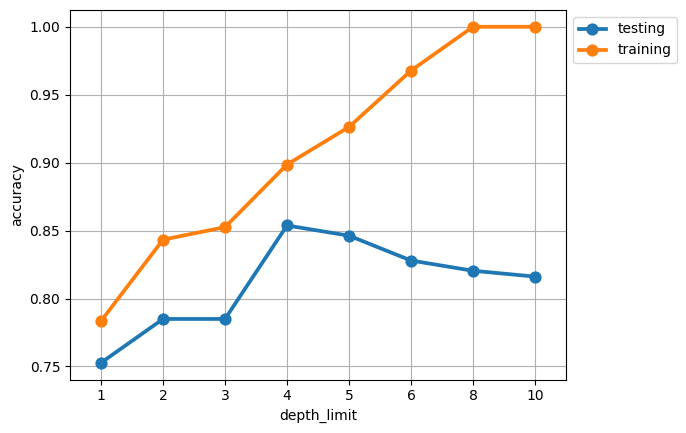

In [35]:
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics

n_runs = 10
depth_limits = [1, 2, 3, 4, 5, 6, 8, 10]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)

# Generates a list composed of 8 lists (one for each depth limit) each containing 10 instances of a decision tree trained with the training data.
predictors = [[tree.DecisionTreeClassifier(max_depth=k).fit(X_train, y_train) for i in range(n_runs)] for k in depth_limits]

# Computes the individual training and testing accuracies for each of the predictors
individual_training_accuracies = map(lambda depth: [metrics.accuracy_score(y_train, predictor.predict(X_train)) for predictor in depth], predictors)
individual_testing_accuracies = map(lambda depth: [metrics.accuracy_score(y_test, predictor.predict(X_test)) for predictor in depth], predictors)

# Averages the training and testing accuracies for each depth limit
training_accuracies = map(lambda depth: sum(depth)/len(depth), individual_training_accuracies)
testing_accuracies = map(lambda depth: sum(depth)/len(depth), individual_testing_accuracies)

# Creates a dataframe with the results in order to plot
testing_accuracies_rows = list(zip(depth_limits, testing_accuracies, ['testing' for i in range(8)]))
training_accuracies_rows = list(zip(depth_limits, training_accuracies, ['training' for i in range(8)]))
data = pd.DataFrame(testing_accuracies_rows + training_accuracies_rows, columns=['depth_limit', 'accuracy', 'type'])

sns.pointplot(x="depth_limit", y="accuracy", data=data, hue='type')
plt.legend(bbox_to_anchor=(1, 1), loc=2)  
plt.grid()
plt.show()

3) Comment on the results, including the generalization capacity across settings.

The model seems to be overfitting when the depth limit surpasses 4, since the training accuracy continues to grow (until it reaches close to 100% at depth 8) while the testing accuracy actually tends to diminuish. The model seems to lack generalization capacity for depth limits bigger than 4.

Although, when the limit is 1, there is a simillar value to testing and training accuracies, that seems to be the case because both of them are pretty low. That fact gets highlighted for limits 2 and 3, where the gap between the accuracies grows.

In conclusion, to get the best case of generalization (avoiding underfitting and overfitting) we would chose a depth limit of 4 for a decision tree trained using this data set.

4) To deploy the predictor, a healthcare team opted to learn a single decision tree
(random_state=0) using all available data as training data, and further ensuring that each leaf has
a minimum of 20 individuals in order to avoid overfitting risks.

i. Plot the decision tree.

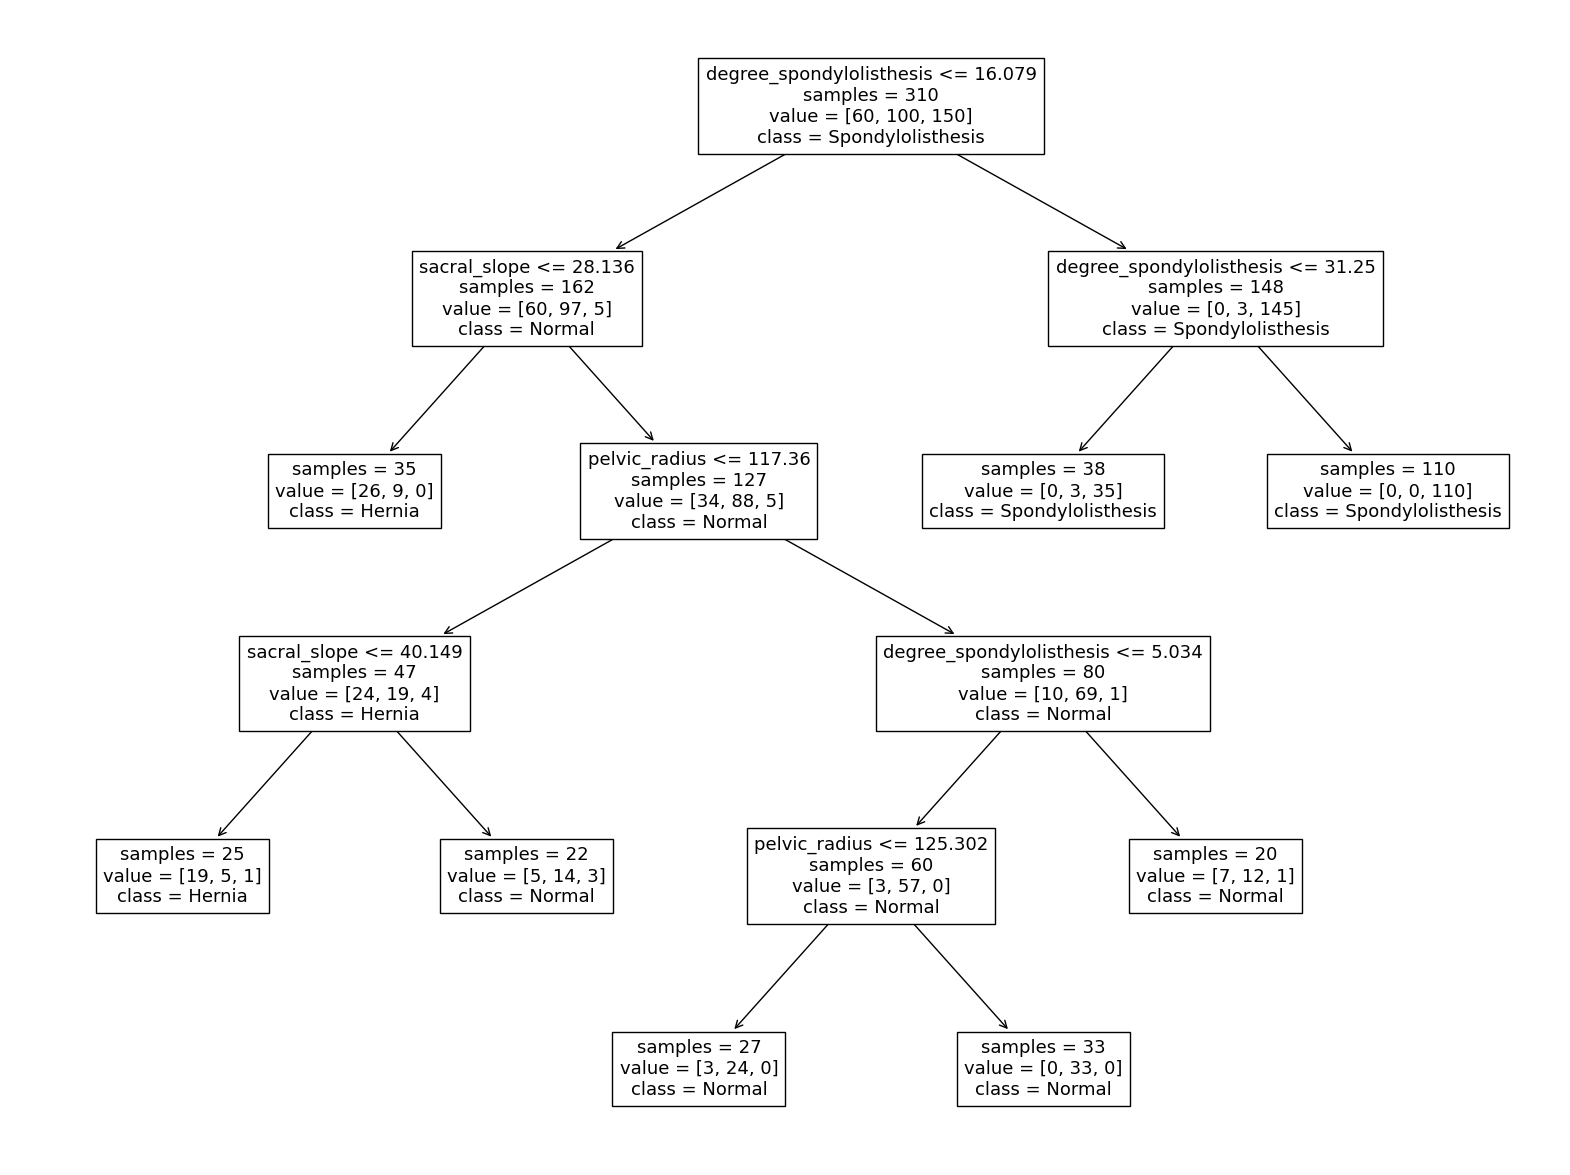

In [7]:
healthcare_predictor = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf=20)
healthcare_predictor.fit(X, y)

figure = plt.figure(figsize=(20, 15))
tree.plot_tree(healthcare_predictor, feature_names=list(X.head(0)), class_names=sorted(list(set(y.values))), impurity=False)
plt.show()

ii. Characterize a hernia condition by identifying the hernia-conditional associations.

The hernia condition can be characterized by the following conditions: spondylolisthesis degree lower or equal to 16.079, sacral slope lower or equal to 28.136 or between 28.136 (excluding) and 40.149 when the pelvic radius is lower or equal to 117.36.

In resume, the following conditions lead to a Hernia diagnosis:

- spondylolisthesis degree $\leq 16.079$ $\land$ sacral slope $\leq 28.136$
- spondylolisthesis degree $\leq 16.079$ $\land$ $28.136 \lt$ sacral slope $\leq 40.149$ $\land$ pelvic radius $\leq 117.36$